In [ ]:
import sys
from pathlib import Path
import pandas as pd

# Notebook cell
%load_ext autoreload
%autoreload 2

# Get root directory (assuming notebook is in root/notebooks/)
NOTEBOOK_DIR = Path.cwd()
ROOT_DIR = NOTEBOOK_DIR.parent if NOTEBOOK_DIR.name == 'notebooks' else NOTEBOOK_DIR

# Add src directory to Python path
sys.path.append(str(ROOT_DIR / 'src'))

# Verify path
print(f"Python will look in these locations:\n{sys.path}")


# --- Execute the processor ---
import utils
from config import DATE_STR, DOWNLOAD_DIR, DEST_DIR

path_data = f'..\data\{DATE_STR}_df_finviz_merged_stocks_etfs.parquet'

print(utils.__file__)  # Should point to your src/utils.py
print(f'path_data: {path_data}')
print((f'DATE_STR: {DATE_STR}'))


Python will look in these locations:
['C:\\Users\\ping\\.pyenv\\pyenv-win\\versions\\3.11.9\\python311.zip', 'C:\\Users\\ping\\.pyenv\\pyenv-win\\versions\\3.11.9\\DLLs', 'C:\\Users\\ping\\.pyenv\\pyenv-win\\versions\\3.11.9\\Lib', 'C:\\Users\\ping\\.pyenv\\pyenv-win\\versions\\3.11.9', 'c:\\Users\\ping\\Files_win10\\python\\py311\\.venv', '', 'c:\\Users\\ping\\Files_win10\\python\\py311\\.venv\\Lib\\site-packages', 'c:\\Users\\ping\\Files_win10\\python\\py311\\.venv\\Lib\\site-packages\\win32', 'c:\\Users\\ping\\Files_win10\\python\\py311\\.venv\\Lib\\site-packages\\win32\\lib', 'c:\\Users\\ping\\Files_win10\\python\\py311\\.venv\\Lib\\site-packages\\Pythonwin', 'c:\\Users\\ping\\Files_win10\\python\\py311\\stocks\\src']
c:\Users\ping\Files_win10\python\py311\stocks\src\utils.py
path_data: ..\data\2025-04-25_df_finviz_merged_stocks_etfs.parquet
date_str: 2025-04-25


In [3]:
import pandas as pd
# Set pandas display options to show more columns and rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 2000)        # Let the display adjust to the window
pd.set_option('display.max_colwidth', None) # Show full content of each cell
pd.set_option('display.max_rows', 200)
pd.set_option('display.float_format', '{:.4f}'.format)

In [4]:
df_finviz = pd.read_parquet(path_data)
print(f'\ndf_finviz.shape: {df_finviz.shape}')
print(df_finviz.head())
print('\n')
print((df_finviz.describe()))


df_finviz.shape: (1518, 139)
        No.                Company               Index                  Sector                        Industry Country Exchange                                                    Info  MktCap AUM, M  Rank  Market Cap, M     P/E  Fwd P/E    PEG     P/S     P/B     P/C   P/FCF  Book/sh  Cash/sh  Dividend %  Dividend TTM Dividend Ex Date  Payout Ratio %     EPS  EPS next Q  EPS this Y %  EPS next Y %  EPS past 5Y %  EPS next 5Y %  Sales past 5Y %  Sales Q/Q %  EPS Q/Q %  EPS YoY TTM %  Sales YoY TTM %    Sales, M   Income, M  EPS Surprise %  Revenue Surprise %  Outstanding, M   Float, M  Float %  Insider Own %  Insider Trans %  Inst Own %  Inst Trans %  Short Float %  Short Ratio  Short Interest, M   ROA %    ROE %   ROI %  Curr R  Quick R  LTDebt/Eq  Debt/Eq  Gross M %  Oper M %  Profit M %  Perf 3D %  Perf Week %  Perf Month %  Perf Quart %  Perf Half %  Perf Year %  Perf YTD %   Beta     ATR  ATR/Price %  Volatility W %  Volatility M %  SMA20 %  SMA50 %  S

In [5]:
print(f'df_finviz.columns:\n{df_finviz.columns}')
print(f'\ndf_finviz.describe():\n{df_finviz.describe()}')
# print(f'\ndf_finviz.head():\n{df_finviz.head()}')
print(f'\ndf_finviz.info():')
print(f'{df_finviz.info()}')

df_finviz.columns:
Index(['No.', 'Company', 'Index', 'Sector', 'Industry', 'Country', 'Exchange', 'Info', 'MktCap AUM, M', 'Rank',
       ...
       'Omega 30d', 'Sharpe 60d', 'Sortino 60d', 'Omega 60d', 'Sharpe 120d', 'Sortino 120d', 'Omega 120d', 'Sharpe 250d', 'Sortino 250d', 'Omega 250d'], dtype='object', length=139)

df_finviz.describe():
            No.  MktCap AUM, M      Rank  Market Cap, M        P/E   Fwd P/E      PEG       P/S       P/B        P/C      P/FCF     Book/sh     Cash/sh  Dividend %  Dividend TTM  Payout Ratio %        EPS  EPS next Q  EPS this Y %  EPS next Y %  EPS past 5Y %  EPS next 5Y %  Sales past 5Y %  Sales Q/Q %   EPS Q/Q %  EPS YoY TTM %  Sales YoY TTM %    Sales, M   Income, M  EPS Surprise %  Revenue Surprise %  Outstanding, M   Float, M   Float %  Insider Own %  Insider Trans %  Inst Own %  Inst Trans %  Short Float %  Short Ratio  Short Interest, M     ROA %     ROE %     ROI %   Curr R  Quick R  LTDebt/Eq   Debt/Eq  Gross M %   Oper M %  Profit M % 

In [6]:
import pandas as pd
import numpy as np
import logging
from scipy.stats import zscore # Assuming z_score_series uses this or similar
from typing import Tuple, Dict, Any # Import necessary types

# --- Placeholder Constants and Functions (replace with your actual implementations) ---
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# --- Expert Recommended Starting Parameters ---
FILTERS = {
    'min_price': 10.0,            # Minimum share price
    'min_avg_volume_m': 2.0,      # Minimum average daily volume in Millions
    'min_roe_pct': 5.0,           # Minimum Return on Equity percentage
    'max_debt_eq': 1.5            # Maximum Debt-to-Equity ratio
}

SCORING_WEIGHTS = {
    'rsi': 0.35,         # Weight for RSI (lower is better)
    'change': 0.35,      # Weight for Change % (lower is better - mean reversion)
    'rel_volume': 0.20,  # Weight for Relative Volume (higher is better - confirmation)
    'volatility': 0.10   # Weight for ATR/Price % (lower is better - risk dampener)
}
# Check that weights sum to 1 (or close enough)
assert abs(sum(SCORING_WEIGHTS.values()) - 1.0) < 1e-9, "Scoring weights must sum to 1.0"


INV_VOL_COL = 'ATR/Price %' # Recommended column for Inverse Volatility Weighting
EPSILON = 1e-9 # Small number to avoid division by zero

# Placeholder Z-score function (adjust if yours is different)
def z_score_series(series: pd.Series) -> pd.Series:
    """Calculates Z-score for a pandas Series, handling NaNs."""
    # Ensure input is numeric before zscoring
    numeric_series = pd.to_numeric(series, errors='coerce')
    if numeric_series.isnull().all(): # Handle case where all values are NaN after coercion
        return pd.Series(np.nan, index=series.index).rename(f"z_{series.name}")
    return pd.Series(zscore(numeric_series, nan_policy='omit'), index=series.index).rename(f"z_{series.name}")

# --- Modified Function ---

def select_short_term_stocks_debug(
    df_finviz,
    # df_cov, # Kept for signature compatibility, but not used in provided logic
    n_select=20,
    filters=FILTERS, # Use recommended defaults
    scoring_weights=SCORING_WEIGHTS, # Use recommended defaults
    inv_vol_col_name=INV_VOL_COL) -> Tuple[pd.DataFrame, pd.DataFrame, Dict[str, Any]]: # Updated return type hint
    """
    Selects stocks with potential for positive returns over the next 1-2 days,
    focusing on mean reversion and volume confirmation. Provides detailed output
    including scores and weights for Equal, Inverse Volatility, and Score-Weighted schemes.

    Uses recommended baseline parameters, but they should be validated via backtesting.

    Args:
        df_finviz (pd.DataFrame): DataFrame with stock metrics (must include columns
                                used in filters and scoring). Index should be Ticker.
        df_cov (pd.DataFrame): Covariance matrix (Index=Ticker, Columns=Ticker).
                               Currently unused in the provided logic but kept for signature.
        n_select (int): Number of top stocks to select *initially*. The actual number
                        selected might be lower if fewer stocks pass filters/scoring.
        filters (dict): Dictionary defining filter thresholds. Uses recommended defaults if not provided.
        scoring_weights (dict): Dictionary defining weights for scoring components. Uses recommended defaults if not provided.
        inv_vol_col_name (str): Column name in df_finviz to use for Inverse Volatility calculation. Uses recommended default if not provided.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame, Dict[str, Any]]:
            - pd.DataFrame: DataFrame with selected tickers as index, including filter/score details
                            and 'Weight_EW', 'Weight_IV', 'Weight_SW' columns.
                            Returns empty DataFrame on failure or if no stocks pass filters/scoring.
            - pd.DataFrame: The DataFrame *after* filtering but *before* scoring/selection.
                            Returns empty DataFrame on failure.
            - Dict[str, Any]: A flat dictionary containing the parameters used for the selection
                              (e.g., {'n_select': 20, 'filter_min_price': 10.0,
                               'score_weight_rsi': 0.35, 'inv_vol_col_name': 'ATR/Price %'}).
    """
    # Store initial n_select value for parameters output
    initial_n_select = n_select

    # --- Log Parameters ---
    logging.info("--- Starting Short-Term Stock Selection (Debug Mode) ---")
    logging.info(f"Initial Parameters: n_select={initial_n_select}")
    logging.info(f"Filters Used: {filters}")
    logging.info(f"Scoring Weights Used: {scoring_weights}")
    logging.info(f"Inverse Volatility Column Used: '{inv_vol_col_name}'")

    # --- Basic Input Validation ---
    if not isinstance(df_finviz, pd.DataFrame) or df_finviz.empty:
        logging.error("Input df_finviz is not a valid DataFrame or is empty.")
        # Create the parameters dict even on failure for consistent return signature
        parameters_used = {
            'n_select_requested': initial_n_select,
            'inv_vol_col_name': inv_vol_col_name
        }
        if isinstance(filters, dict):
            for k, v in filters.items(): parameters_used[f'filter_{k}'] = v
        if isinstance(scoring_weights, dict):
            for k, v in scoring_weights.items(): parameters_used[f'score_weight_{k}'] = v
        return pd.DataFrame(), pd.DataFrame(), parameters_used

    if not isinstance(filters, dict) or not isinstance(scoring_weights, dict):
        logging.error("Filters and scoring_weights must be dictionaries.")
        parameters_used = {
            'n_select_requested': initial_n_select,
            'inv_vol_col_name': inv_vol_col_name
        }
        # Attempt to add parameters even if types are wrong, might fail if not iterable
        try:
            if isinstance(filters, dict):
                 for k, v in filters.items(): parameters_used[f'filter_{k}'] = v
            if isinstance(scoring_weights, dict):
                 for k, v in scoring_weights.items(): parameters_used[f'score_weight_{k}'] = v
        except: pass # Ignore errors during parameter gathering on failure
        return pd.DataFrame(), pd.DataFrame(), parameters_used


    if abs(sum(scoring_weights.values()) - 1.0) > EPSILON:
         logging.warning(f"Scoring weights provided do not sum to 1.0 (Sum={sum(scoring_weights.values())}). Proceeding, but normalization might be affected.")

    df = df_finviz.copy()
    df_after_filter = pd.DataFrame() # Initialize for return

    # --- [Existing code sections 1 through 6 remain unchanged] ---
    # 1. Define Required Columns based on Inputs
    filter_cols = ['Price', 'Avg Volume, M', 'ROE %', 'Debt/Eq']
    score_input_cols = ['RSI', 'Change %', 'Rel Volume', 'ATR/Price %']
    inv_vol_req_col = [inv_vol_col_name] if inv_vol_col_name else []
    required_cols = list(set(filter_cols + score_input_cols + inv_vol_req_col))
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        logging.error(f"Missing required columns in df_finviz: {missing_cols}. Required based on filters/weights/inv_vol_col: {required_cols}")
        parameters_used = {
            'n_select_requested': initial_n_select, 'inv_vol_col_name': inv_vol_col_name
        }
        if isinstance(filters, dict):
            for k, v in filters.items(): parameters_used[f'filter_{k}'] = v
        if isinstance(scoring_weights, dict):
            for k, v in scoring_weights.items(): parameters_used[f'score_weight_{k}'] = v
        return pd.DataFrame(), pd.DataFrame(), parameters_used

    # 2. Data Preparation and Cleaning
    logging.debug("Converting required columns to numeric...")
    for col in required_cols:
        if col in df.columns and not pd.api.types.is_numeric_dtype(df[col]):
            df[col] = pd.to_numeric(df[col], errors='coerce')
    initial_count = len(df)
    df.dropna(subset=required_cols, inplace=True)
    cleaned_count = len(df)
    logging.info(f"Cleaned data: Removed {initial_count - cleaned_count} rows with NaNs in essential columns ({required_cols}). {cleaned_count} remaining.")
    if cleaned_count == 0:
        logging.warning("No stocks remaining after NaN cleaning.")
        parameters_used = {
            'n_select_requested': initial_n_select, 'inv_vol_col_name': inv_vol_col_name
        }
        if isinstance(filters, dict):
            for k, v in filters.items(): parameters_used[f'filter_{k}'] = v
        if isinstance(scoring_weights, dict):
            for k, v in scoring_weights.items(): parameters_used[f'score_weight_{k}'] = v
        return pd.DataFrame(), pd.DataFrame(), parameters_used

    # 3. Filtering
    logging.info("Applying filters...")
    try:
        filter_mask = pd.Series(True, index=df.index)
        if 'min_price' in filters: filter_mask &= (df['Price'] >= filters['min_price'])
        if 'min_avg_volume_m' in filters: filter_mask &= (df['Avg Volume, M'] >= filters['min_avg_volume_m'])
        if 'min_roe_pct' in filters: filter_mask &= (df['ROE %'] >= filters['min_roe_pct'])
        if 'max_debt_eq' in filters: filter_mask &= (df['Debt/Eq'] <= filters['max_debt_eq'])
        df_filtered = df[filter_mask].copy()
        df_after_filter = df_filtered.copy()
        filtered_count = len(df_filtered)
        logging.info(f"Filtering complete: {filtered_count} stocks passed filters.")
    except KeyError as e:
        logging.error(f"Filtering failed. Check keys. Missing column/key: {e}. Filters: {filters}")
        parameters_used = {
            'n_select_requested': initial_n_select, 'inv_vol_col_name': inv_vol_col_name
        }
        if isinstance(filters, dict):
            for k, v in filters.items(): parameters_used[f'filter_{k}'] = v
        if isinstance(scoring_weights, dict):
            for k, v in scoring_weights.items(): parameters_used[f'score_weight_{k}'] = v
        return pd.DataFrame(), pd.DataFrame(), parameters_used # Return empty dfs, params
    except Exception as e:
         logging.error(f"An unexpected error occurred during filtering: {e}")
         parameters_used = {
             'n_select_requested': initial_n_select, 'inv_vol_col_name': inv_vol_col_name
         }
         if isinstance(filters, dict):
             for k, v in filters.items(): parameters_used[f'filter_{k}'] = v
         if isinstance(scoring_weights, dict):
             for k, v in scoring_weights.items(): parameters_used[f'score_weight_{k}'] = v
         return pd.DataFrame(), pd.DataFrame(), parameters_used

    if filtered_count == 0:
        logging.warning("No stocks passed the filtering criteria.")
        parameters_used = {
            'n_select_requested': initial_n_select, 'inv_vol_col_name': inv_vol_col_name
        }
        if isinstance(filters, dict):
            for k, v in filters.items(): parameters_used[f'filter_{k}'] = v
        if isinstance(scoring_weights, dict):
            for k, v in scoring_weights.items(): parameters_used[f'score_weight_{k}'] = v
        return pd.DataFrame(), df_after_filter, parameters_used # Return empty selection, filtered df, params
    elif filtered_count < n_select:
        logging.warning(f"Only {filtered_count} stocks passed filters, less than n_select ({n_select}). Selecting all {filtered_count}.")
        n_select = filtered_count # Adjust n_select

    # 4. Scoring
    logging.info("Calculating component scores (Z-scores)...")
    try:
        z_rsi = z_score_series(df_filtered['RSI']).rename('z_RSI')
        z_change = z_score_series(df_filtered['Change %']).rename('z_Change%')
        z_rel_volume = z_score_series(df_filtered['Rel Volume']).rename('z_RelVolume')
        z_volatility = z_score_series(df_filtered['ATR/Price %']).rename('z_ATR/Price%')
        final_score = (
            z_rsi * scoring_weights.get('rsi', 0) * (-1) +
            z_change * scoring_weights.get('change', 0) * (-1) +
            z_rel_volume * scoring_weights.get('rel_volume', 0) * (1) +
            z_volatility * scoring_weights.get('volatility', 0) * (-1)
        ).rename('final_score').fillna(0)
    except KeyError as e:
        logging.error(f"Scoring failed. Missing column/key: {e}. Weights: {scoring_weights}")
        parameters_used = {
            'n_select_requested': initial_n_select, 'inv_vol_col_name': inv_vol_col_name
        }
        if isinstance(filters, dict):
            for k, v in filters.items(): parameters_used[f'filter_{k}'] = v
        if isinstance(scoring_weights, dict):
            for k, v in scoring_weights.items(): parameters_used[f'score_weight_{k}'] = v
        return pd.DataFrame(), df_after_filter, parameters_used
    except Exception as e:
         logging.error(f"An unexpected error occurred during scoring: {e}")
         parameters_used = {
             'n_select_requested': initial_n_select, 'inv_vol_col_name': inv_vol_col_name
         }
         if isinstance(filters, dict):
             for k, v in filters.items(): parameters_used[f'filter_{k}'] = v
         if isinstance(scoring_weights, dict):
             for k, v in scoring_weights.items(): parameters_used[f'score_weight_{k}'] = v
         return pd.DataFrame(), df_after_filter, parameters_used

    # 5. Combine Data & Rank
    df_debug = pd.concat([
        df_filtered[required_cols], z_rsi, z_change, z_rel_volume, z_volatility, final_score
    ], axis=1)
    logging.info(f"Top 5 Stocks based on Intermediate Scores:\n{df_debug.sort_values('final_score', ascending=False).head(5)}")

    # 6. Selection
    logging.info(f"Ranking stocks by final_score and selecting top {n_select}...")
    n_select = min(n_select, len(df_debug)) # Ensure n_select is not > available
    if n_select == 0:
        logging.warning("No stocks available for selection after scoring/ranking.")
        parameters_used = {
            'n_select_requested': initial_n_select, 'n_select_actual': 0, 'inv_vol_col_name': inv_vol_col_name
        }
        if isinstance(filters, dict):
            for k, v in filters.items(): parameters_used[f'filter_{k}'] = v
        if isinstance(scoring_weights, dict):
            for k, v in scoring_weights.items(): parameters_used[f'score_weight_{k}'] = v
        return pd.DataFrame(), df_after_filter, parameters_used

    df_ranked = df_debug.sort_values('final_score', ascending=False)
    df_selected = df_ranked.head(n_select).copy()
    actual_n_select = len(df_selected) # Store the actual number selected

    # --- 7. Weighting (Unchanged Logic) ---
    logging.info(f"Applying 'EqualWeight', 'InverseVolatility', and 'ScoreWeighted' schemes...")
    # -- Equal Weight (EW) --
    df_selected['Weight_EW'] = 1.0 / actual_n_select if actual_n_select > 0 else 0
    # -- Inverse Volatility Weight (IV) --
    if not inv_vol_col_name or inv_vol_col_name not in df_selected.columns:
        df_selected['Weight_IV'] = np.nan
    else:
        volatility = pd.to_numeric(df_selected[inv_vol_col_name], errors='coerce')
        valid_vol_mask = volatility.notna() & (volatility > EPSILON)
        volatility.loc[~valid_vol_mask] = np.inf
        inv_vol = (1.0 / volatility).replace([np.inf, -np.inf], 0).fillna(0)
        total_inv_vol = inv_vol.sum()
        if total_inv_vol > EPSILON: df_selected['Weight_IV'] = inv_vol / total_inv_vol
        else: df_selected['Weight_IV'] = df_selected['Weight_EW'] # Fallback
    # -- Score Weighted (SW) --
    scores = pd.to_numeric(df_selected['final_score'], errors='coerce').fillna(0)
    min_score = scores.min()
    if min_score < 0: scores = scores - min_score # Shift to non-negative
    total_score = scores.sum()
    if abs(total_score) > EPSILON: df_selected['Weight_SW'] = scores / total_score
    else: df_selected['Weight_SW'] = df_selected['Weight_EW'] # Fallback

    # --- 8. Final Checks (Unchanged Logic) ---
    weight_cols = ['Weight_EW', 'Weight_IV', 'Weight_SW']
    for w_col in weight_cols:
        # ... (sum checks remain the same) ...
        if w_col in df_selected.columns and pd.api.types.is_numeric_dtype(df_selected[w_col]):
             weight_sum = df_selected[w_col].sum()
             if pd.isna(weight_sum): logging.warning(f"Weight sum for '{w_col}' resulted in NaN.")
             elif not np.isclose(weight_sum, 1.0, atol=EPSILON): logging.warning(f"Final weights for '{w_col}' do not sum close to 1.0 (Sum = {weight_sum:.6f}). Check calculations.")
        elif w_col in df_selected.columns: logging.warning(f"Weight column '{w_col}' exists but is not numeric.")


    logging.info(f"Selected Stocks ({actual_n_select} stocks) with Scores and Weights (Top {min(5, actual_n_select)} shown):\n{df_selected.head(min(5, actual_n_select))}")


    # --- 9. Prepare Parameters Dictionary for Output ---
    parameters_used = {
        'n_select_requested': initial_n_select, # The n_select passed into the function
        'n_select_actual': actual_n_select,     # The number actually selected (might be lower)
        'inv_vol_col_name': inv_vol_col_name
    }
    # Flatten filters into the dictionary
    if isinstance(filters, dict):
        for k, v in filters.items():
            parameters_used[f'filter_{k}'] = v
    # Flatten scoring_weights into the dictionary
    if isinstance(scoring_weights, dict):
        for k, v in scoring_weights.items():
            parameters_used[f'score_weight_{k}'] = v

    logging.info("--- Short-Term Stock Selection Finished ---")


    # --- 10. Return Results ---
    return df_selected, df_after_filter, parameters_used

In [7]:
import pandas as pd
import os # Assume df_finviz, df_cov are loaded pandas DataFrames

# Set up logging
# setup_logging("my_short_term_run_debug.log")

# --- RUN SELECTION ---
# Note: No 'weighting_scheme' argument needed here as both are calculated
df_selected_stocks, df_filtered, parameters_used = select_short_term_stocks_debug(
    df_finviz=df_finviz,  # Your DataFrame with metrics
    # df_cov=df_cov,  # Pass covariance matrix (might be used later for MinVar etc.)
    n_select=10,  # Number of stocks to select
    # Optional: Specify which column to use for IV weighting if not default 'Volatility M %'
    # inv_vol_col_name='ATR/Price %',
    # Optionally pass custom filters or scoring_weights dictionaries
    # filters = {...},
    # scoring_weights = {...}
)

# --- Display Results ---
if not df_selected_stocks.empty:
    print("\nSelected Stocks (Detailed Output with Scores & Weights):")
    # Display more columns for context
    display_cols = ['final_score', 'Weight_EW', 'Weight_IV', 'Weight_SW','RSI', 'Change %', 'Rel Volume', INV_VOL_COL]
    # Ensure display_cols exist before trying to display them
    display_cols = [col for col in display_cols if col in df_selected_stocks.columns]
    print(df_selected_stocks[display_cols])

    # You can now easily extract the weights for backtesting:
    # weights_ew = df_selected_stocks[['Weight_EW']].rename(columns={'Weight_EW':'Weight'})
    # weights_iv = df_selected_stocks[['Weight_IV']].rename(columns={'Weight_IV':'Weight'})
else:
    print("\nNo stocks were selected.")

# --- Display Parameters Used ---
print("\nParameters Used for Selection:")
for k, v in parameters_used.items():
    print(f"{k}: {v}")

2025-05-11 12:59:21,498 - INFO - --- Starting Short-Term Stock Selection (Debug Mode) ---
2025-05-11 12:59:21,498 - INFO - Initial Parameters: n_select=10
2025-05-11 12:59:21,498 - INFO - Filters Used: {'min_price': 10.0, 'min_avg_volume_m': 2.0, 'min_roe_pct': 5.0, 'max_debt_eq': 1.5}
2025-05-11 12:59:21,514 - INFO - Scoring Weights Used: {'rsi': 0.35, 'change': 0.35, 'rel_volume': 0.2, 'volatility': 0.1}
2025-05-11 12:59:21,514 - INFO - Inverse Volatility Column Used: 'ATR/Price %'
2025-05-11 12:59:21,539 - INFO - Cleaned data: Removed 453 rows with NaNs in essential columns (['ROE %', 'Rel Volume', 'Price', 'RSI', 'Change %', 'ATR/Price %', 'Avg Volume, M', 'Debt/Eq']). 1065 remaining.
2025-05-11 12:59:21,555 - INFO - Applying filters...
2025-05-11 12:59:21,556 - INFO - Filtering complete: 287 stocks passed filters.
2025-05-11 12:59:21,556 - INFO - Calculating component scores (Z-scores)...
2025-05-11 12:59:21,581 - INFO - Top 5 Stocks based on Intermediate Scores:
         ROE %  R


Selected Stocks (Detailed Output with Scores & Weights):
        final_score  Weight_EW  Weight_IV  Weight_SW     RSI  Change %  Rel Volume  ATR/Price %
Ticker                                                                                         
AVTR         6.1170     0.1000     0.0651     0.2981 30.6100  -16.5800      5.1700       7.0379
CNC          2.2117     0.1000     0.1045     0.1078 40.8900   -6.3200      1.8100       4.3855
SKX          1.9912     0.1000     0.0709     0.0970 40.3400   -5.3500      1.9700       6.4658
UNH          1.7797     0.1000     0.0835     0.0867 27.7200   -1.3200      1.5800       5.4868
FI           1.6334     0.1000     0.0828     0.0796 30.6900    0.3600      2.2300       5.5371
FUTU         1.5368     0.1000     0.0584     0.0749 46.5400   -6.4300      1.5000       7.8429
GILD         1.4356     0.1000     0.1153     0.0700 41.0500   -2.8100      1.5100       3.9740
TAP          1.3625     0.1000     0.1454     0.0664 37.7200   -2.6600      0.

In [ ]:
import pandas as pd
import json
import os
import logging
from typing import Tuple, Dict, Any, Optional

# Assume logger is configured elsewhere, or configure basic here
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def save_selection_results(
    df_selected: pd.DataFrame,
    parameters_used: Dict[str, Any],
    base_filepath: str,
    save_csv: bool = False # Option to also save as CSV for inspection
    ) -> bool:
    """
    Saves the selected stocks DataFrame and parameters dictionary to files.

    Saves DataFrame primarily as Parquet and parameters as JSON.
    Optionally saves DataFrame as CSV as well.

    Args:
        df_selected (pd.DataFrame): The DataFrame containing selected stocks and details.
        parameters_used (Dict[str, Any]): The flat dictionary of parameters used.
        base_filepath (str): The base path and filename *without* extension.
                            Example: 'results/selection_run_20231027'
        save_csv (bool, optional): If True, also saves the DataFrame as a CSV file.
                                  Defaults to False.

    Returns:
        bool: True if all intended save operations were successful, False otherwise.
    """
    success = True
    parquet_file = f"{base_filepath}.parquet"
    json_file = f"{base_filepath}_params.json"
    csv_file = f"{base_filepath}.csv"

    # Ensure the directory exists
    try:
        output_dir = os.path.dirname(base_filepath)
        if output_dir and not os.path.exists(output_dir):
            os.makedirs(output_dir)
            logging.info(f"Created output directory: {output_dir}")
    except Exception as e:
        logging.error(f"Failed to create directory for {base_filepath}: {e}")
        return False # Cannot proceed if directory creation fails

    # --- Save DataFrame as Parquet ---
    try:
        if not df_selected.empty:
            df_selected.to_parquet(parquet_file, engine='pyarrow', compression='zstd', index=True)
            logging.info(f"Successfully saved selected stocks DataFrame to Parquet: {parquet_file}")
        else:
            logging.warning(f"Selected stocks DataFrame is empty. Parquet file not saved: {parquet_file}")
            # We might consider this a partial success depending on requirements
            # Set success = False if saving an empty df isn't acceptable
    except Exception as e:
        logging.error(f"Failed to save DataFrame to Parquet ({parquet_file}): {e}")
        success = False

    # --- Optionally save DataFrame as CSV ---
    if save_csv:
        try:
            if not df_selected.empty:
                df_selected.to_csv(csv_file, index=True) # IMPORTANT: Save the index (Tickers)
                logging.info(f"Successfully saved selected stocks DataFrame to CSV: {csv_file}")
            else:
                logging.warning(f"Selected stocks DataFrame is empty. CSV file not saved: {csv_file}")
        except Exception as e:
            logging.error(f"Failed to save DataFrame to CSV ({csv_file}): {e}")
            success = False # Treat failure to save optional CSV as overall failure if desired

    # --- Save Parameters as JSON ---
    try:
        with open(json_file, 'w') as f:
            json.dump(parameters_used, f, indent=4) # Use indent for readability
        logging.info(f"Successfully saved parameters to JSON: {json_file}")
    except TypeError as e:
         logging.error(f"Failed to serialize parameters to JSON ({json_file}). Check for non-serializable types: {e}")
         success = False
    except Exception as e:
        logging.error(f"Failed to save parameters to JSON ({json_file}): {e}")
        success = False

    return success


def load_selection_results(
    base_filepath: str
    ) -> Tuple[Optional[pd.DataFrame], Optional[Dict[str, Any]]]:
    """
    Loads the selected stocks DataFrame and parameters dictionary from files.

    Attempts to load DataFrame from Parquet first, then falls back to CSV if specified.
    Loads parameters from JSON.

    Args:
        base_filepath (str): The base path and filename *without* extension,
                            matching the one used in save_selection_results.
                            Example: 'results/selection_run_20231027'

    Returns:
        Tuple[Optional[pd.DataFrame], Optional[Dict[str, Any]]]:
            A tuple containing:
            - The loaded DataFrame (or None if loading failed or file not found).
            - The loaded parameters dictionary (or None if loading failed or file not found).
    """
    df_selected = None
    parameters_used = None

    parquet_file = f"{base_filepath}.parquet"
    json_file = f"{base_filepath}_params.json"
    csv_file = f"{base_filepath}.csv" # For fallback

    # --- Load DataFrame ---
    # Prioritize Parquet
    if os.path.exists(parquet_file):
        try:
            df_selected = pd.read_parquet(parquet_file, engine='pyarrow')
            logging.info(f"Successfully loaded DataFrame from Parquet: {parquet_file}")
        except Exception as e:
            logging.error(f"Failed to load DataFrame from Parquet ({parquet_file}): {e}")
            # Optionally, try CSV here if Parquet fails to load but exists
            # For now, we just log error and proceed to check CSV explicitly below

    # Fallback to CSV if Parquet doesn't exist (or failed loading - though we don't explicitly retry here)
    if df_selected is None and os.path.exists(csv_file):
        logging.info(f"Parquet file ({parquet_file}) not found or failed to load. Attempting to load from CSV: {csv_file}")
        try:
            # IMPORTANT: Use index_col=0 to read the first column as the index
            df_selected = pd.read_csv(csv_file, index_col=0)
            logging.info(f"Successfully loaded DataFrame from CSV: {csv_file}")
        except Exception as e:
            logging.error(f"Failed to load DataFrame from CSV ({csv_file}): {e}")
    elif df_selected is None:
        logging.warning(f"Could not find Parquet ({parquet_file}) or CSV ({csv_file}) for DataFrame.")


    # --- Load Parameters from JSON ---
    if os.path.exists(json_file):
        try:
            with open(json_file, 'r') as f:
                parameters_used = json.load(f)
            logging.info(f"Successfully loaded parameters from JSON: {json_file}")
        except json.JSONDecodeError as e:
            logging.error(f"Failed to decode JSON from file ({json_file}): {e}")
        except Exception as e:
            logging.error(f"Failed to load parameters from JSON ({json_file}): {e}")
    else:
        logging.warning(f"Parameters JSON file not found: {json_file}")


    # --- Final Check ---
    if df_selected is None and parameters_used is None:
        logging.error(f"Failed to load both DataFrame and Parameters for base path: {base_filepath}")

    return df_selected, parameters_used



# 1. Saving the results
base_filename = f"output/selection_results/{DATE_STR}_my_selection_run_1" # Example path/filename
logging.info(f"\n--- Attempting to Save Results ---")
save_successful = save_selection_results(
    df_selected=df_selected_stocks,
    parameters_used=parameters_used,
    base_filepath=base_filename,
    save_csv=True # Also save CSV for checking
)

if save_successful:
    print(f"\nResults saved successfully for base path: {base_filename}")
else:
    print(f"\nSaving results failed for base path: {base_filename}")


# 2. Loading the results later
logging.info(f"\n--- Attempting to Load Results ---")
loaded_df, loaded_params = load_selection_results(base_filename)

if loaded_df is not None:
    print("\nLoaded DataFrame:")
    print(loaded_df)
else:
    print("\nFailed to load DataFrame.")

if loaded_params is not None:
    print("\nLoaded Parameters:")
    print(json.dumps(loaded_params, indent=2)) # Pretty print loaded JSON
else:
    print("\nFailed to load parameters.")

2025-05-11 12:59:21,952 - INFO - 
--- Attempting to Save Results ---
2025-05-11 12:59:21,963 - INFO - Successfully saved selected stocks DataFrame to Parquet: output/selection_results/2025-04-25_my_selection_run_1.parquet
2025-05-11 12:59:21,983 - INFO - Successfully saved selected stocks DataFrame to CSV: output/selection_results/2025-04-25_my_selection_run_1.csv
2025-05-11 12:59:21,989 - INFO - Successfully saved parameters to JSON: output/selection_results/2025-04-25_my_selection_run_1_params.json
2025-05-11 12:59:21,992 - INFO - 
--- Attempting to Load Results ---
2025-05-11 12:59:22,022 - INFO - Successfully loaded DataFrame from Parquet: output/selection_results/2025-04-25_my_selection_run_1.parquet
2025-05-11 12:59:22,024 - INFO - Successfully loaded parameters from JSON: output/selection_results/2025-04-25_my_selection_run_1_params.json



Results saved successfully for base path: output/selection_results/2025-04-25_my_selection_run_1

Loaded DataFrame:
         ROE %  Rel Volume    Price     RSI  Change %  ATR/Price %  Avg Volume, M  Debt/Eq   z_RSI  z_Change%  z_RelVolume  z_ATR/Price%  final_score  Weight_EW  Weight_IV  Weight_SW
Ticker                                                                                                                                                                                
AVTR   12.5200      5.1700  12.9300 30.6100  -16.5800       7.0379         8.4400   0.6700 -3.0464    -8.7602      10.8832        1.9199       6.1170     0.1000     0.0651     0.2981
CNC    12.5900      1.8100  57.6900 40.8900   -6.3200       4.3855         4.7200   0.6600 -1.5191    -3.3438       2.5577        0.0190       2.2117     0.1000     0.1045     0.1078
SKX    14.6700      1.9700  47.7900 40.3400   -5.3500       6.4658         3.2400   0.4800 -1.6008    -2.8317       2.9541        1.5099       1.9912  

In [9]:
import pandas as pd
from typing import List, Optional

def add_columns_from_source(
    base_df: pd.DataFrame,
    source_df: pd.DataFrame,
    cols_to_add: List[str],
    match_col_base: Optional[str] = None, # Default to None now
    match_on_base_index: bool = False   # New flag to match on base index
) -> pd.DataFrame:
    """
    Adds specified columns from a source DataFrame to a base DataFrame,
    placing the added columns to the left of the original base columns.

    Rows are matched based on either a specified column in the base DataFrame
    OR the index of the base DataFrame, against the *index* of the source
    DataFrame.

    Args:
        base_df (pd.DataFrame):
            The DataFrame to which the columns will be added.
        source_df (pd.DataFrame):
            The DataFrame containing the column data to add. Its index MUST
            contain the keys for matching (e.g., Tickers).
        cols_to_add (List[str]):
            A list of string names of the columns in `source_df` to retrieve data from.
        match_col_base (Optional[str], optional):
            The string name of the column in `base_df` containing the keys
            (e.g., Tickers) used for matching against the `source_df` index.
            Required if `match_on_base_index` is False. Defaults to None.
        match_on_base_index (bool, optional):
            If True, use the index of `base_df` for matching against the
            `source_df` index. If False (default), use the column specified
            by `match_col_base`. Defaults to False.

    Returns:
        pd.DataFrame: A new DataFrame, with the specified `cols_to_add` from
                      `source_df` appearing first (on the left), followed by
                      all columns from the original `base_df`.
                      Values are mapped based on the specified matching criteria.
                      Returns NaN for the added columns where no match is found.

    Raises:
        KeyError: If `match_on_base_index` is False and `match_col_base` is None
                  or not in `base_df.columns`.
                  If any column in `cols_to_add` is not in `source_df.columns`.
        ValueError: If `cols_to_add` is empty, or if both `match_col_base`
                    is provided and `match_on_base_index` is True (ambiguous).
    """
    # --- Input validation ---
    if not cols_to_add:
        raise ValueError("The 'cols_to_add' list cannot be empty.")

    if match_on_base_index and match_col_base is not None:
        raise ValueError("Cannot specify both 'match_col_base' and 'match_on_base_index=True'. Choose one matching method.")
    if not match_on_base_index and match_col_base is None:
         raise ValueError("Must specify 'match_col_base' if 'match_on_base_index' is False.")

    if not match_on_base_index:
        if match_col_base not in base_df.columns:
            raise KeyError(f"Matching column '{match_col_base}' not found in base_df columns: {base_df.columns.tolist()}")
        match_key_description = f"column '{match_col_base}'"
    else:
        match_key_description = "index" # For warning messages


    missing_source_cols = [col for col in cols_to_add if col not in source_df.columns]
    if missing_source_cols:
        raise KeyError(f"Columns to add {missing_source_cols} not found in source_df columns: {source_df.columns.tolist()}")

    # --- Perform the merge ---
    # Select only the columns needed from the source to avoid unnecessary merging
    source_subset = source_df[cols_to_add]

    # Store original base columns for later reordering
    original_base_columns = base_df.columns.tolist()

    # Build arguments for pd.merge dynamically
    merge_kwargs = {
        'right': source_subset,
        'right_index': True,      # Always merge on the source's index
        'how': 'left',            # Keep all rows from base_df
        'suffixes': ('', '_source') # Add suffix if col name conflict occurs
    }

    if match_on_base_index:
        merge_kwargs['left_index'] = True # Use base_df's index
    else:
        merge_kwargs['left_on'] = match_col_base # Use specified base_df column

    # Execute the merge
    merged_df = pd.merge(
        base_df,
        **merge_kwargs
    )

    # --- Reorder columns ---
    # Identify the actual names of the columns added (handling potential suffixes)
    all_merged_cols = merged_df.columns.tolist()
    # Columns are considered "added" if they were NOT in the original base_df
    added_cols_actual_names = [col for col in all_merged_cols if col not in original_base_columns]

    # Create the desired final column order
    new_column_order = added_cols_actual_names + original_base_columns

    # Apply the new order
    # Use reindex to ensure all expected columns are present, handling potential edge cases
    final_df = merged_df.reindex(columns=new_column_order)


    # --- Optional: Add warnings for NaNs in added columns ---
    # Use the actual names of the added columns after merge for checking
    total_rows = len(final_df)
    for col_name in added_cols_actual_names:
        # Check if column exists (it should, due to reindex)
        if col_name in final_df.columns:
            num_nas = final_df[col_name].isna().sum()
            if num_nas > 0:
                print(f"Warning: {num_nas}/{total_rows} entries for added column '{col_name}' are NaN.")
                if num_nas == total_rows:
                     print(f"   -> Check if values in the base_df {match_key_description} exist in the index of the source DataFrame.")
        else:
             # This case should ideally not happen with the reindex approach
             print(f"Warning: Expected added column '{col_name}' was not found in the final reordered DataFrame.")


    return final_df


In [10]:
cols_to_add = ['Company', 'Industry', 'Market Cap, M', 'Rank']
new_df_multiple_success = add_columns_from_source(
    base_df=df_selected_stocks, # Use the DataFrame from previous selection
    source_df=df_finviz,
    cols_to_add=cols_to_add,
    match_on_base_index=True # <-- Tell the function to use base_df's index
)
print("\n--- Result DataFrame (Multiple Columns - Success) ---")
print(new_df_multiple_success)


--- Result DataFrame (Multiple Columns - Success) ---
                              Company                         Industry  Market Cap, M  Rank   ROE %  Rel Volume    Price     RSI  Change %  ATR/Price %  Avg Volume, M  Debt/Eq   z_RSI  z_Change%  z_RelVolume  z_ATR/Price%  final_score  Weight_EW  Weight_IV  Weight_SW
Ticker                                                                                                                                                                                                                                                                     
AVTR                      Avantor Inc   Medical Instruments & Supplies      8810.0000  1094 12.5200      5.1700  12.9300 30.6100  -16.5800       7.0379         8.4400   0.6700 -3.0464    -8.7602      10.8832        1.9199       6.1170     0.1000     0.0651     0.2981
CNC                      Centene Corp                 Healthcare Plans     28620.0000   470 12.5900      1.8100  57.6900 40.8900   -6.3200   

### Verification Calculation

In [11]:
print(f"df_filtered.columns:\n{df_filtered.columns}")

df_filtered.columns:
Index(['No.', 'Company', 'Index', 'Sector', 'Industry', 'Country', 'Exchange', 'Info', 'MktCap AUM, M', 'Rank',
       ...
       'Omega 30d', 'Sharpe 60d', 'Sortino 60d', 'Omega 60d', 'Sharpe 120d', 'Sortino 120d', 'Omega 120d', 'Sharpe 250d', 'Sortino 250d', 'Omega 250d'], dtype='object', length=139)


In [12]:
# Get a ticker from the selected stocks
selected_ticker = df_selected_stocks.index[1]
print(f"Selected Ticker: {selected_ticker}")  # This should print the ticker name

Selected Ticker: CNC


In [13]:
verification_calc = {}

In [14]:
# Get selected ticker's RSI value
selected_ticker_rsi = df_filtered.loc[selected_ticker, 'RSI']

# Calculate mean and std of RSI for all stocks
rsi_mean = df_filtered['RSI'].mean()
# Use population standard deviation (ddof=0) to match scipy.stats.zscore default
rsi_std = df_filtered['RSI'].std(ddof=0) # <--- CHANGE MADE HERE

# Calculate z-score
z_rsi = (selected_ticker_rsi - rsi_mean) / rsi_std

# Store results in verification_calc dictionary as standard Python float
verification_calc['rsi'] =  float(z_rsi)

print(f"Calculated {selected_ticker} RSI: {selected_ticker_rsi:.4f}")
print(f"Calculated RSI Mean: {rsi_mean:.4f}")
print(f"Calculated RSI Std Dev: {rsi_std:.4f}")
print(f"Calulated {selected_ticker} RSI Z-Score: {z_rsi:.4f}")

print(f"\ndf_selected_stocks.loc[selected_ticker, 'z_RSI']: {df_selected_stocks.loc[selected_ticker, 'z_RSI']:.4f}")

Calculated CNC RSI: 40.8900
Calculated RSI Mean: 51.1155
Calculated RSI Std Dev: 6.7312
Calulated CNC RSI Z-Score: -1.5191

df_selected_stocks.loc[selected_ticker, 'z_RSI']: -1.5191


In [15]:
# Get selected ticker's 'Change %' value
selected_ticker_change = df_filtered.loc[selected_ticker, 'Change %']

# Calculate mean and std of change for all stocks
change_mean = df_filtered['Change %'].mean()
change_std = df_filtered['Change %'].std(ddof=0)

# Calculate z-score
z_change = (selected_ticker_change - change_mean) / change_std

# Store results in verification_calc dictionary as standard Python float
verification_calc['change'] =  float(z_change) 

print(f"Calculated {selected_ticker} Change %: {selected_ticker_change:.4f}")
print(f"Calculated Change % Mean: {change_mean:.4f}")
print(f"Calculated Change % Std Dev: {change_std:.4f}")
print(f"Calulated {selected_ticker} Change % Z-Score: {z_change:.4f}")

print(f"\ndf_selected_stocks.loc[selected_ticker, 'z_Change%']: {df_selected_stocks.loc[selected_ticker, 'z_Change%']:.4f}")

Calculated CNC Change %: -6.3200
Calculated Change % Mean: 0.0139
Calculated Change % Std Dev: 1.8942
Calulated CNC Change % Z-Score: -3.3438

df_selected_stocks.loc[selected_ticker, 'z_Change%']: -3.3438


In [16]:
# Get selected ticker's Rel Volume value
selected_ticker_rsi = df_filtered.loc[selected_ticker, 'Rel Volume']

# Calculate mean and std of Rel Volume for all stocks
rel_vol_mean = df_filtered['Rel Volume'].mean()
rel_vol_std = df_filtered['Rel Volume'].std(ddof=0)

# Calculate z-score
z_rel_vol = (selected_ticker_rsi - rel_vol_mean) / rel_vol_std

# Store results in verification_calc dictionary as standard Python float
verification_calc['rel_volume'] =  float(z_rel_vol)  

print(f"Calculated {selected_ticker} Rel Volume: {selected_ticker_rsi:.4f}")
print(f"Calculated Rel Volume Mean: {rel_vol_mean:.4f}")
print(f"Calculated Rel Volume Std Dev: {rel_vol_std:.4f}")
print(f"Calulated {selected_ticker} Rel Volume Z-Score: {z_rel_vol:.4f}")

print(f"\ndf_selected_stocks.loc[selected_ticker, 'z_RelVolume']: {df_selected_stocks.loc[selected_ticker, 'z_RelVolume']:.4f}")

Calculated CNC Rel Volume: 1.8100
Calculated Rel Volume Mean: 0.7778
Calculated Rel Volume Std Dev: 0.4036
Calulated CNC Rel Volume Z-Score: 2.5577

df_selected_stocks.loc[selected_ticker, 'z_RelVolume']: 2.5577


In [17]:
# Get selected ticker's 'ATR/Price %' value
selected_ticker_ATR_Price = df_filtered.loc[selected_ticker, 'ATR/Price %']

# Calculate mean and std of ATR_Price for all stocks
ATR_Price_mean = df_filtered['ATR/Price %'].mean()
ATR_Price_std = df_filtered['ATR/Price %'].std(ddof=0)

# Calculate z-score
z_atr_price = (selected_ticker_ATR_Price - ATR_Price_mean) / ATR_Price_std

# Store results in verification_calc dictionary as standard Python float
verification_calc['volatility'] =  float(z_atr_price)

print(f"Calculated {selected_ticker} ATR/Price %: {selected_ticker_ATR_Price:.4f}")
print(f"Calculated ATR/Price % Mean: {ATR_Price_mean:.4f}")
print(f"Calculated ATR/Price % Std Dev: {ATR_Price_std:.4f}")
print(f"Calulated {selected_ticker} ATR/Price % Z-Score: {z_atr_price:.4f}")

print(f"\ndf_selected_stocks.loc[selected_ticker, 'z_ATR/Price%']: {df_selected_stocks.loc[selected_ticker, 'z_ATR/Price%']:.4f}")

Calculated CNC ATR/Price %: 4.3855
Calculated ATR/Price % Mean: 4.3590
Calculated ATR/Price % Std Dev: 1.3953
Calulated CNC ATR/Price % Z-Score: 0.0190

df_selected_stocks.loc[selected_ticker, 'z_ATR/Price%']: 0.0190


In [18]:
print(f'SCORING_WEIGHTS: {SCORING_WEIGHTS}')
print(f'verification_calc: {verification_calc}')

SCORING_WEIGHTS: {'rsi': 0.35, 'change': 0.35, 'rel_volume': 0.2, 'volatility': 0.1}
verification_calc: {'rsi': -1.5191283028967522, 'change': -3.343800846981422, 'rel_volume': 2.557685654626854, 'volatility': 0.01899083051718491}


In [19]:
final_score_verification_calc = (
    verification_calc['rsi'] * SCORING_WEIGHTS['rsi'] * (-1) +              # Lower RSI -> Higher Score
    verification_calc['change'] * SCORING_WEIGHTS['change'] * (-1) +        # Lower Change% -> Higher Score
    verification_calc['rel_volume'] * SCORING_WEIGHTS['rel_volume'] * (1) + # Higher RelVol -> Higher Score
    verification_calc['volatility'] * SCORING_WEIGHTS['volatility'] * (-1)  # Lower ATR/Price% -> Higher Score
)

print(f"Final Score Verification Calculation: {final_score_verification_calc:.4f}")
print(f"\ndf_selected_stocks.loc[selected_ticker, 'final_score']: {df_selected_stocks.loc[selected_ticker, 'final_score']:.4f}")

Final Score Verification Calculation: 2.2117

df_selected_stocks.loc[selected_ticker, 'final_score']: 2.2117


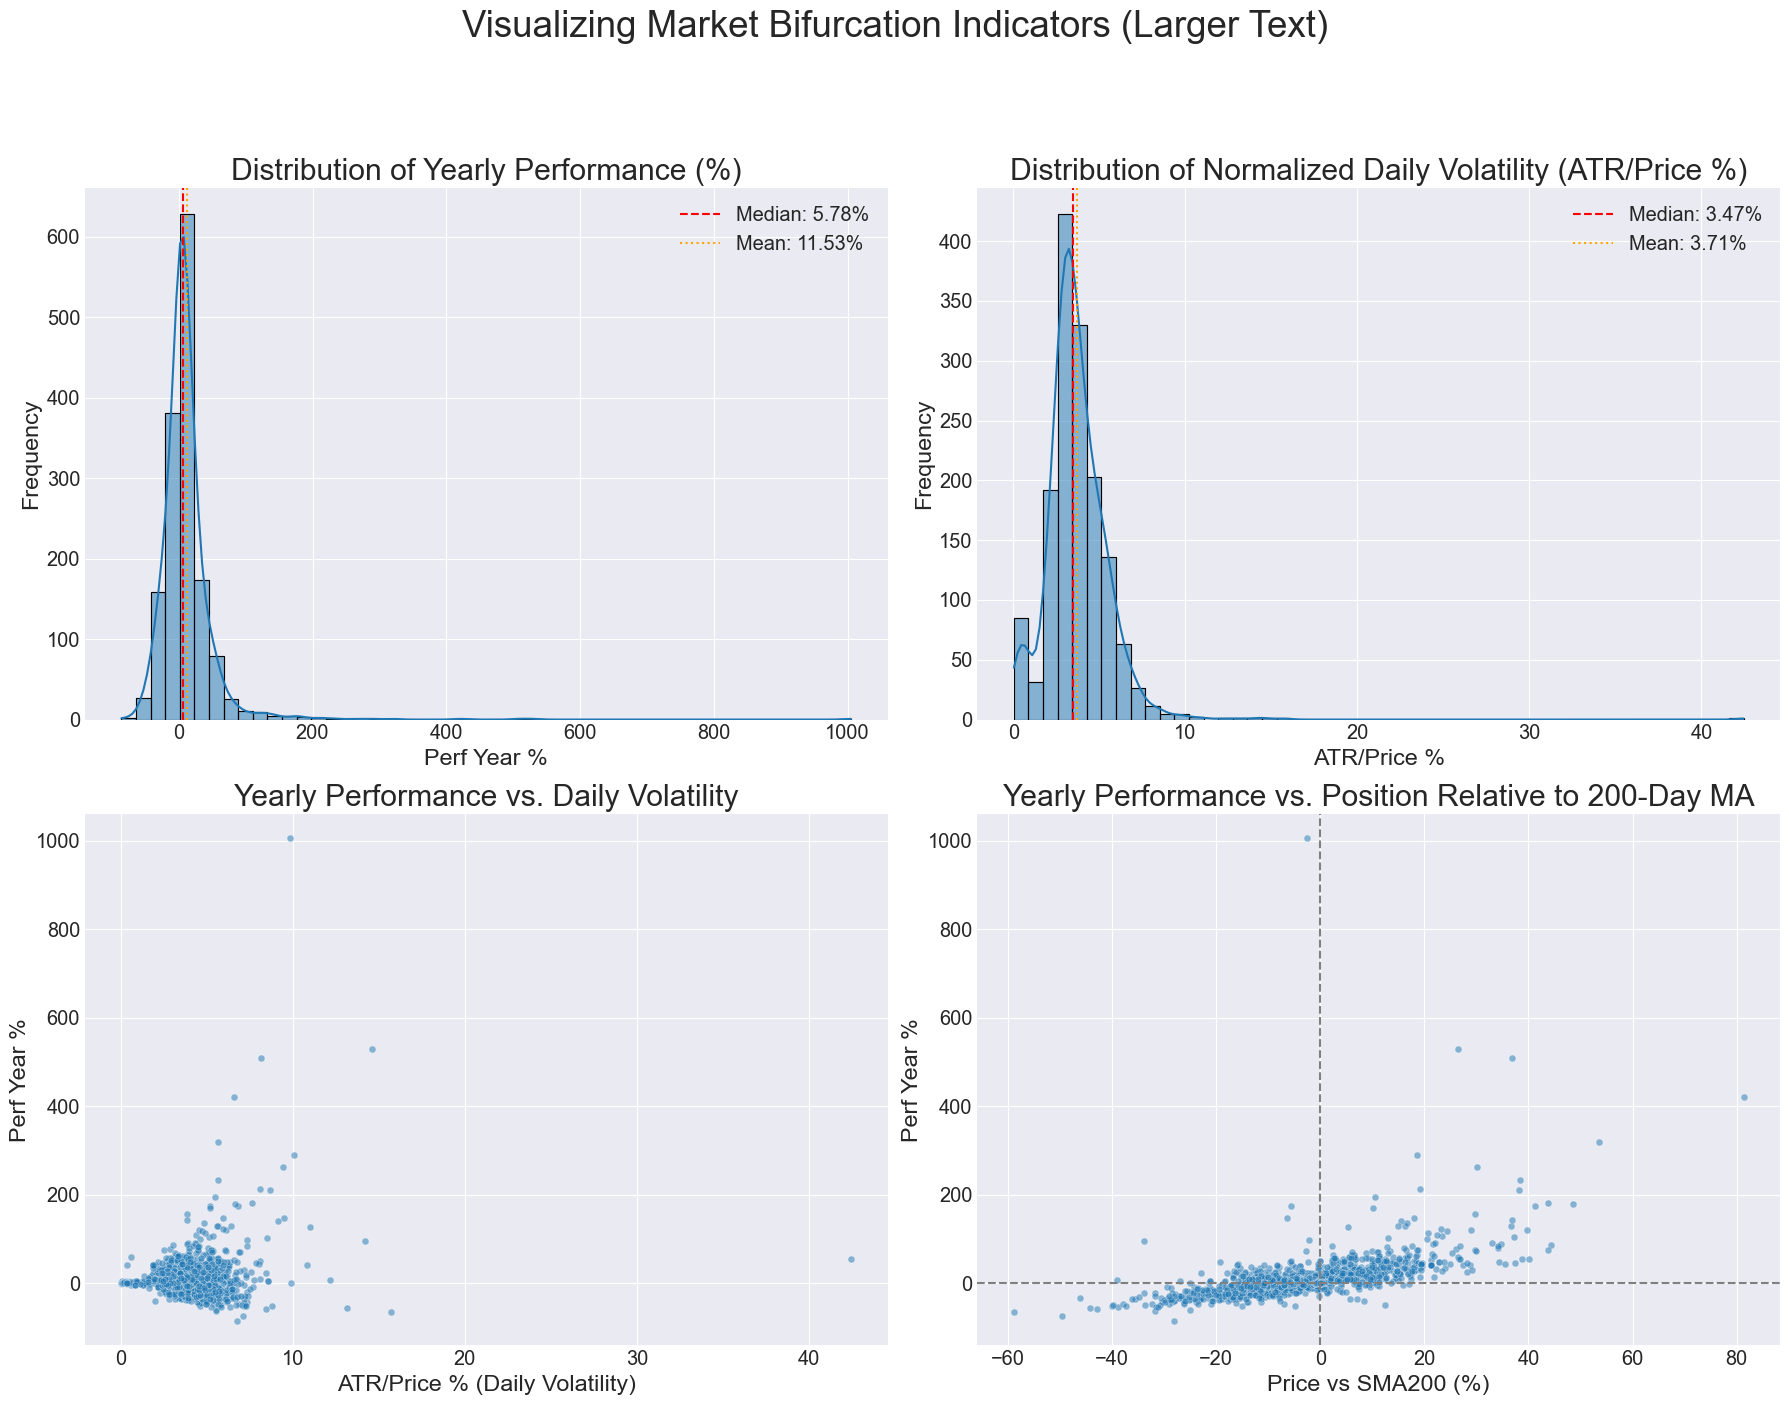

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np # Will be used if we need to handle potential infinite values if any

# --- IMPORTANT ---
# Ensure your DataFrame is named df_finviz and contains the columns used below.
# Example: (replace this with your actual data loading)
# df_finviz = pd.read_csv('your_market_data.csv')

# --- Data Cleaning (Optional but Recommended) ---
# Replace potential infinite values with NaN
df_finviz.replace([np.inf, -np.inf], np.nan, inplace=True)
# Use a copy to avoid modifying original if needed later
df_plot = df_finviz.copy()

# --- Font Size Definitions ---
SCALE_FONTSIZE = 1.2  # Scale factor for font sizes
TITLE_FONTSIZE = 18 * SCALE_FONTSIZE
AXIS_LABEL_FONTSIZE = 14 * SCALE_FONTSIZE
TICK_LABEL_FONTSIZE = 12 * SCALE_FONTSIZE
LEGEND_FONTSIZE = 12 * SCALE_FONTSIZE
SUPTITLE_FONTSIZE = 22 * SCALE_FONTSIZE

# --- Visualization ---

plt.style.use('seaborn-v0_8-darkgrid') # Use a visually appealing style
fig, axes = plt.subplots(2, 2, figsize=(18, 14)) # Increased figure size slightly for larger text
fig.suptitle('Visualizing Market Bifurcation Indicators (Larger Text)', fontsize=SUPTITLE_FONTSIZE, y=1.03) # Adjusted y position slightly

# 1. Histogram of Yearly Performance ('Perf Year %')
sns.histplot(data=df_plot, x='Perf Year %', kde=True, ax=axes[0, 0], bins=50)
axes[0, 0].set_title('Distribution of Yearly Performance (%)', fontsize=TITLE_FONTSIZE)
axes[0, 0].set_xlabel('Perf Year %', fontsize=AXIS_LABEL_FONTSIZE)
axes[0, 0].set_ylabel('Frequency', fontsize=AXIS_LABEL_FONTSIZE) # Added y-axis label
axes[0, 0].tick_params(axis='both', which='major', labelsize=TICK_LABEL_FONTSIZE)
median_val = df_plot['Perf Year %'].median()
mean_val = df_plot['Perf Year %'].mean()
axes[0, 0].axvline(median_val, color='red', linestyle='--', label=f'Median: {median_val:.2f}%')
axes[0, 0].axvline(mean_val, color='orange', linestyle=':', label=f'Mean: {mean_val:.2f}%')
axes[0, 0].legend(fontsize=LEGEND_FONTSIZE)

# 2. Histogram of Normalized Volatility ('ATR/Price %')
sns.histplot(data=df_plot, x='ATR/Price %', kde=True, ax=axes[0, 1], bins=50)
axes[0, 1].set_title('Distribution of Normalized Daily Volatility (ATR/Price %)', fontsize=TITLE_FONTSIZE)
axes[0, 1].set_xlabel('ATR/Price %', fontsize=AXIS_LABEL_FONTSIZE)
axes[0, 1].set_ylabel('Frequency', fontsize=AXIS_LABEL_FONTSIZE) # Added y-axis label
axes[0, 1].tick_params(axis='both', which='major', labelsize=TICK_LABEL_FONTSIZE)
median_val = df_plot['ATR/Price %'].median()
mean_val = df_plot['ATR/Price %'].mean()
axes[0, 1].axvline(median_val, color='red', linestyle='--', label=f'Median: {median_val:.2f}%')
axes[0, 1].axvline(mean_val, color='orange', linestyle=':', label=f'Mean: {mean_val:.2f}%')
axes[0, 1].legend(fontsize=LEGEND_FONTSIZE)

# 3. Scatter Plot: Yearly Performance vs. Normalized Volatility
sns.scatterplot(data=df_plot, x='ATR/Price %', y='Perf Year %', ax=axes[1, 0], alpha=0.5, s=25) # Slightly larger points
axes[1, 0].set_title('Yearly Performance vs. Daily Volatility', fontsize=TITLE_FONTSIZE)
axes[1, 0].set_xlabel('ATR/Price % (Daily Volatility)', fontsize=AXIS_LABEL_FONTSIZE)
axes[1, 0].set_ylabel('Perf Year %', fontsize=AXIS_LABEL_FONTSIZE)
axes[1, 0].tick_params(axis='both', which='major', labelsize=TICK_LABEL_FONTSIZE)

# 4. Scatter Plot: Yearly Performance vs. Distance from 200-Day MA
sns.scatterplot(data=df_plot, x='SMA200 %', y='Perf Year %', ax=axes[1, 1], alpha=0.5, s=25) # Slightly larger points
axes[1, 1].set_title('Yearly Performance vs. Position Relative to 200-Day MA', fontsize=TITLE_FONTSIZE)
axes[1, 1].set_xlabel('Price vs SMA200 (%)', fontsize=AXIS_LABEL_FONTSIZE)
axes[1, 1].set_ylabel('Perf Year %', fontsize=AXIS_LABEL_FONTSIZE)
axes[1, 1].tick_params(axis='both', which='major', labelsize=TICK_LABEL_FONTSIZE)
axes[1, 1].axvline(0, color='grey', linestyle='--') # Line at 0% (on the SMA200)
axes[1, 1].axhline(0, color='grey', linestyle='--') # Line at 0% Perf Year

plt.tight_layout(rect=[0, 0.03, 1, 0.97]) # Adjust layout slightly for suptitle
plt.show()